In [10]:
import numpy as np
import pandas as pd 
import cmath 
import scipy.special as sp
import scipy.constants as const
import matplotlib.pyplot as plt
import lmfit
import seaborn as sns
sns.set_theme()
plt.rcParams['legend.facecolor'] = 'white'

https://lmfit.github.io/lmfit-py/examples/example_complex_resonator_model.html

Using the model based on this page ^. 

In [11]:
def linear_resonator(f, f_0, Q, Q_e_real, Q_e_imag):
    Q_e = Q_e_real + 1j*Q_e_imag
    return 1 - (Q * Q_e**-1 / (1 + 2j * Q * (f - f_0) / f_0))

In [12]:
class ResonatorModel(lmfit.model.Model):
    __doc__ = "resonator model" + lmfit.models.COMMON_INIT_DOC

    def __init__(self, *args, **kwargs):
        # pass in the defining equation so the user doesn't have to later
        super().__init__(linear_resonator, *args, **kwargs)

        self.set_param_hint('Q', min=0)  # enforce Q is positive

    def guess(self, data, f=None, **kwargs):
        verbose = kwargs.pop('verbose', None)
        if f is None:
            return
        argmin_s21 = np.abs(data).argmin()
        fmin = f.min()
        fmax = f.max()
        f_0_guess = f[argmin_s21]  # guess that the resonance is the lowest point
        Q_min = 0.1 * (f_0_guess/(fmax-fmin))  # assume the user isn't trying to fit just a small part of a resonance curve
        delta_f = np.diff(f)  # assume f is sorted
        min_delta_f = delta_f[delta_f > 0].min()
        Q_max = f_0_guess/min_delta_f  # assume data actually samples the resonance reasonably
        Q_guess = np.sqrt(Q_min*Q_max)  # geometric mean, why not?
        Q_e_real_guess = Q_guess/(1-np.abs(data[argmin_s21]))
        if verbose:
            print(f"fmin={fmin}, fmax={fmax}, f_0_guess={f_0_guess}")
            print(f"Qmin={Q_min}, Q_max={Q_max}, Q_guess={Q_guess}, Q_e_real_guess={Q_e_real_guess}")
        params = self.make_params(Q=Q_guess, Q_e_real=Q_e_real_guess, Q_e_imag=0, f_0=f_0_guess)
        params[f'{self.prefix}Q'].set(min=Q_min, max=Q_max)
        params[f'{self.prefix}f_0'].set(min=fmin, max=fmax)
        return lmfit.models.update_param_vals(params, self.prefix, **kwargs)

Text(0.5, 1.0, 'simulated measurement')

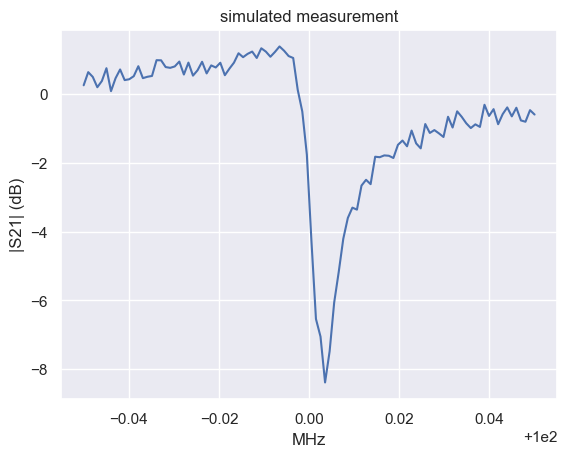

In [13]:
resonator = ResonatorModel()
true_params = resonator.make_params(f_0=100, Q=10000, Q_e_real=9000, Q_e_imag=-9000)

f = np.linspace(99.95, 100.05, 100)
true_s21 = resonator.eval(params=true_params, f=f)
noise_scale = 0.02
np.random.seed(123)
measured_s21 = true_s21 + noise_scale*(np.random.randn(100) + 1j*np.random.randn(100))

plt.plot(f, 20*np.log10(np.abs(measured_s21)))
plt.ylabel('|S21| (dB)')
plt.xlabel('MHz')
plt.title('simulated measurement')

In [14]:
guess = resonator.guess(measured_s21, f=f, verbose=True)

fmin=99.95, fmax=100.05, f_0_guess=100.00353535353536
Qmin=100.00353535354105, Q_max=99003.50000055433, Q_guess=3146.537781821432, Q_e_real_guess=5082.2474265369565


In [15]:
result = resonator.fit(measured_s21, params=guess, f=f, verbose=True)

print(result.fit_report() + '\n')
result.params.pretty_print()

[[Model]]
    Model(linear_resonator)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 41
    # data points      = 200
    # variables        = 4
    chi-square         = 0.08533642
    reduced chi-square = 4.3539e-04
    Akaike info crit   = -1543.89425
    Bayesian info crit = -1530.70099
    R-squared          = (-12528141463360.852+2276419598550.2983j)
[[Variables]]
    f_0:       100.000096 +/- 7.0309e-05 (0.00%) (init = 100.0035)
    Q:         10059.4972 +/- 142.294636 (1.41%) (init = 3146.538)
    Q_e_real:  9180.62017 +/- 133.777681 (1.46%) (init = 5082.247)
    Q_e_imag: -9137.03667 +/- 133.769692 (1.46%) (init = 0)
[[Correlations]] (unreported correlations are < 0.100)
    C(Q, Q_e_real)   = +0.5175
    C(f_0, Q_e_imag) = +0.5175
    C(f_0, Q_e_real) = +0.5151
    C(Q, Q_e_imag)   = -0.5150

Name         Value      Min      Max   Stderr     Vary     Expr Brute_Step
Q         1.006e+04      100  9.9e+04    142.3     True     None     None
Q_e_imag 

Text(0.5, 0, 'MHz')

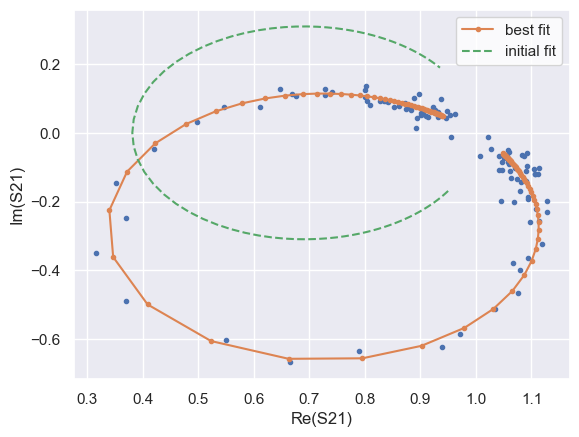

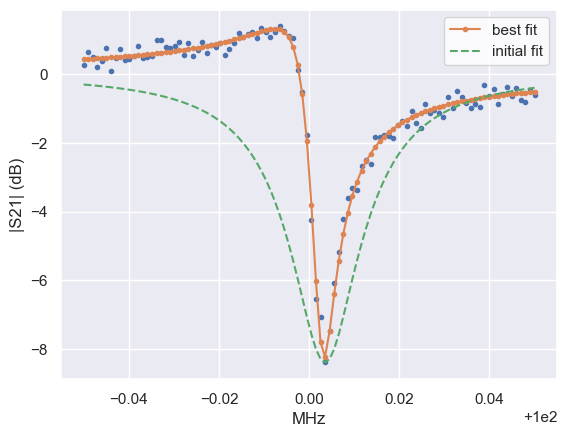

In [16]:
def plot_ri(data, *args, **kwargs):
    plt.plot(data.real, data.imag, *args, **kwargs)


fit_s21 = resonator.eval(params=result.params, f=f)
guess_s21 = resonator.eval(params=guess, f=f)

plt.figure()
plot_ri(measured_s21, '.')
plot_ri(fit_s21, '.-', label='best fit')
plot_ri(guess_s21, '--', label='initial fit')
plt.legend()
plt.xlabel('Re(S21)')
plt.ylabel('Im(S21)')

plt.figure()
plt.plot(f, 20*np.log10(np.abs(measured_s21)), '.')
plt.plot(f, 20*np.log10(np.abs(fit_s21)), '.-', label='best fit')
plt.plot(f, 20*np.log10(np.abs(guess_s21)), '--', label='initial fit')
plt.legend()
plt.ylabel('|S21| (dB)')
plt.xlabel('MHz')

### Applying model to own data @ 3.41 GHz coupling 

In [36]:
p11p5_complex = pd.read_csv('/Users/leayamashiro/AliCPT/whispering_gallery/S21_csvs/0.1 to 1.5 2/IMAG_S21S11_GapSweep_0.1to1.5.csv', skiprows=4)


In [37]:
p11p5_complex

,% x_strip (m),freq (GHz),S11 (1),S21 (1)
0,0.0001,3.4155,0.5821822608240503-0.2704892369954046i,-0.1547086042006699+0.3734905277427347i
1,0.0001,3.4156,0.0013907797837959812-0.5533926103365598i,-0.7356875412010879+0.09202287125138481i
2,0.0001,3.4157,-0.10965305461493058-0.37968711153824475i,-0.8462454165099037+0.26598780559615065i
3,0.0001,3.4158,-0.12202287343461293-0.3057325128063054i,-0.8583795141749605+0.3400555230224109i
4,0.0001,3.4159,-0.12224479743144834-0.26804070696179116i,-0.85844449614518+0.37785498256564176i
...,...,...,...,...
1546,0.0015,3.4161,-0.041460566300162816+0.06362937004880326i,-0.8314306695782707-0.5324605487191933i
1547,0.0015,3.4162,0.2529750878703432-0.10469403377841284i,-0.5372293651529945-0.7007953214088891i
1548,0.0015,3.4163,-0.010907723799300051+0.012387089834692368i,-0.800999973289261-0.5835669220847941i
1549,0.0015,3.4164,-0.01854030732337264+0.023148905652718946i,-0.8086674108225823-0.5727400042326467i


In [38]:
# Clean up the complex strings (replace 'i' with 'j')
p11p5_complex['S21_clean'] = p11p5_complex['S21 (1)'].str.replace('i', 'j', regex=False)

# Convert to actual complex numbers
s21 = p11p5_complex['S21_clean'].astype(complex).to_numpy()

# Frequency array
freq = p11p5_complex['freq (GHz)'].to_numpy()

In [42]:
resonator = ResonatorModel()

# Guess initial params
guess_all = resonator.guess(s21, f=freq, verbose=True)

# Fit
result = resonator.fit(s21, params=guess_all, f=freq, verbose=True)

# Print results
print(result.fit_report())

fmin=3.4155, fmax=3.4165, f_0_guess=3.415600000000001
Qmin=341.5600000000377, Q_max=34156.000000231295, Q_guess=3415.6000000117533, Q_e_real_guess=4717.312260421705
[[Model]]
    Model(linear_resonator)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 958
    # data points      = 3102
    # variables        = 4
    chi-square         = 185.815401
    reduced chi-square = 0.05997915
    Akaike info crit   = -8724.28086
    Bayesian info crit = -8700.12165
    R-squared          = (1.5336856463233408e+17+5478277470344979j)
[[Variables]]
    f_0:       3.41649999 +/- 2.6228e-04 (0.01%) (init = 3.4156)
    Q:         341.560001 +/- 7.23321953 (2.12%) (init = 3415.6)
    Q_e_real:  181.352457 +/- 9.74271702 (5.37%) (init = 4717.312)
    Q_e_imag: -19.5019783 +/- 9.74094944 (49.95%) (init = 0)
[[Correlations]] (unreported correlations are < 0.100)
    C(Q, Q_e_real)   = +0.9980
    C(f_0, Q_e_imag) = +0.9980


Text(0.5, 0, 'MHz')

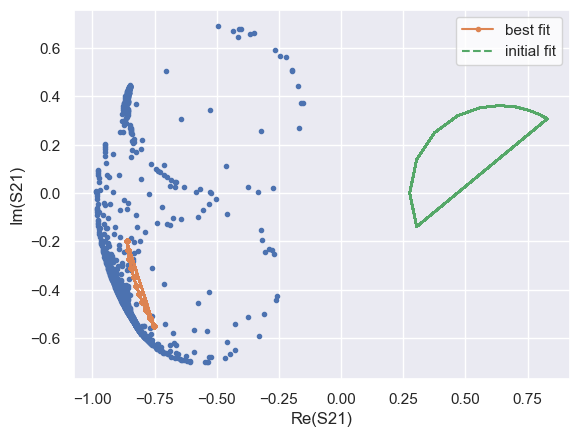

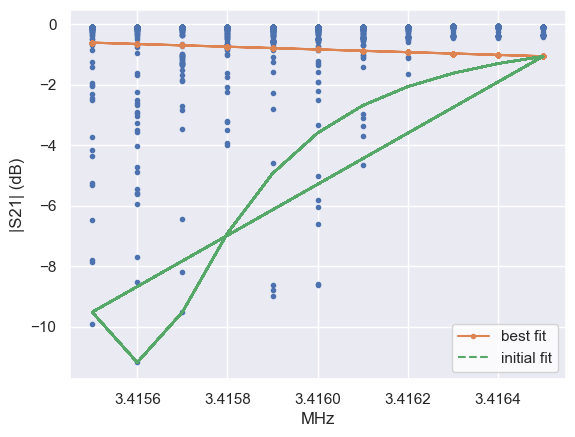

In [43]:
def plot_ri(data, *args, **kwargs):
    plt.plot(data.real, data.imag, *args, **kwargs)


fit_s21 = resonator.eval(params=result.params, f=freq)
guess_s21 = resonator.eval(params=guess_all, f=freq)

plt.figure()
plot_ri(s21, '.')
plot_ri(fit_s21, '.-', label='best fit')
plot_ri(guess_s21, '--', label='initial fit')
plt.legend()
plt.xlabel('Re(S21)')
plt.ylabel('Im(S21)')

plt.figure()
plt.plot(freq, 20*np.log10(np.abs(s21)), '.')
plt.plot(freq, 20*np.log10(np.abs(fit_s21)), '.-', label='best fit')
plt.plot(freq, 20*np.log10(np.abs(guess_s21)), '--', label='initial fit')
plt.legend()
plt.ylabel('|S21| (dB)')
plt.xlabel('MHz')

#### Try fitting with just one gap distance 

In [39]:
p11p5_0p0001 = p11p5_complex[p11p5_complex['% x_strip (m)']==0.0001]
p11p5_0p0001

,% x_strip (m),freq (GHz),S11 (1),S21 (1),S21_clean
0,0.0001,3.4155,0.5821822608240503-0.2704892369954046i,-0.1547086042006699+0.3734905277427347i,-0.1547086042006699+0.3734905277427347j
1,0.0001,3.4156,0.0013907797837959812-0.5533926103365598i,-0.7356875412010879+0.09202287125138481i,-0.7356875412010879+0.09202287125138481j
2,0.0001,3.4157,-0.10965305461493058-0.37968711153824475i,-0.8462454165099037+0.26598780559615065i,-0.8462454165099037+0.26598780559615065j
3,0.0001,3.4158,-0.12202287343461293-0.3057325128063054i,-0.8583795141749605+0.3400555230224109i,-0.8583795141749605+0.3400555230224109j
4,0.0001,3.4159,-0.12224479743144834-0.26804070696179116i,-0.85844449614518+0.37785498256564176i,-0.85844449614518+0.37785498256564176j
5,0.0001,3.4160,-0.12046110817117184-0.24557758153916068i,-0.8565351765951129+0.40042951164182383i,-0.8565351765951129+0.40042951164182383j
6,0.0001,3.4161,-0.11849130322811796-0.23074951107801703i,-0.8544548677641663+0.4153725230410469i,-0.8544548677641663+0.4153725230410469j
7,0.0001,3.4162,-0.11671384103108173-0.22026355655729654i,-0.8525751981970473+0.4259758949657385i,-0.8525751981970473+0.4259758949657385j
8,0.0001,3.4163,-0.11518406418446259-0.2124652022256518i,-0.8509483351034933+0.4338936257506265i,-0.8509483351034933+0.4338936257506265j
9,0.0001,3.4164,-0.11388246404750624-0.20644565388230438i,-0.8495532567544217+0.4400339264095652i,-0.8495532567544217+0.4400339264095652j


In [40]:
s21_p1 = p11p5_0p0001['S21_clean'].astype(complex).to_numpy()
freq_p1 = p11p5_0p0001['freq (GHz)'].to_numpy()

print(s21_p1)
print(freq_p1)

[-0.1547086 +0.37349053j -0.73568754+0.09202287j -0.84624542+0.26598781j
 -0.85837951+0.34005552j -0.8584445 +0.37785498j -0.85653518+0.40042951j
 -0.85445487+0.41537252j -0.8525752 +0.42597589j -0.85094834+0.43389363j
 -0.84955326+0.44003393j -0.84835113+0.44493808j]
[3.4155 3.4156 3.4157 3.4158 3.4159 3.416  3.4161 3.4162 3.4163 3.4164
 3.4165]


In [41]:
resonator = ResonatorModel()

# Guess initial params
guess_p1 = resonator.guess(s21_p1, f=freq_p1, verbose=True)

# Fit
result = resonator.fit(s21_p1, params=guess_p1, f=freq_p1, verbose=True)

# Print results
print(result.fit_report())

fmin=3.4155, fmax=3.4165, f_0_guess=3.4155
Qmin=341.5500000000377, Q_max=34155.00000023128, Q_guess=3415.5000000117525, Q_e_real_guess=5733.250740919941
[[Model]]
    Model(linear_resonator)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 129
    # data points      = 22
    # variables        = 4
    chi-square         = 0.53046458
    reduced chi-square = 0.02947025
    Akaike info crit   = -73.9509801
    Bayesian info crit = -69.5868103
    R-squared          = (-0.01364745364268427-0.8841270332408483j)
[[Variables]]
    f_0:       3.41647485 +/- 1.24517979 (36.45%) (init = 3.4155)
    Q:         341.556598 +/- 155.027226 (45.39%) (init = 3415.5)
    Q_e_real:  178.954068 +/- 84.9860393 (47.49%) (init = 5733.251)
    Q_e_imag:  53.7883784 +/- 85.0612758 (158.14%) (init = 0)
[[Correlations]] (unreported correlations are < 0.100)
    C(f_0, Q_e_imag) = -0.9250
    C(Q, Q_e_real)   = +0.9249
    C(Q, Q_e_imag)   = +0.3761
    C(f_0, Q_e_real) = +0.3738


Text(0.5, 0, 'MHz')

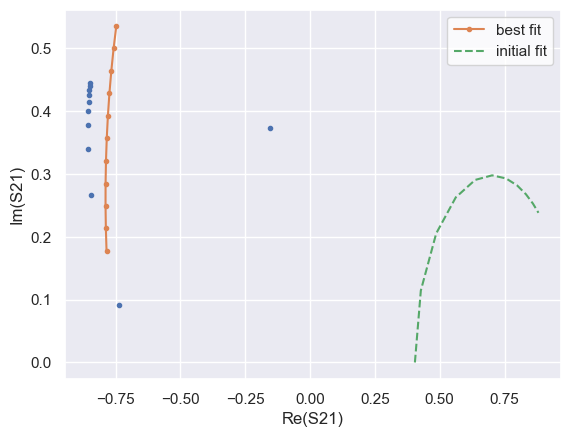

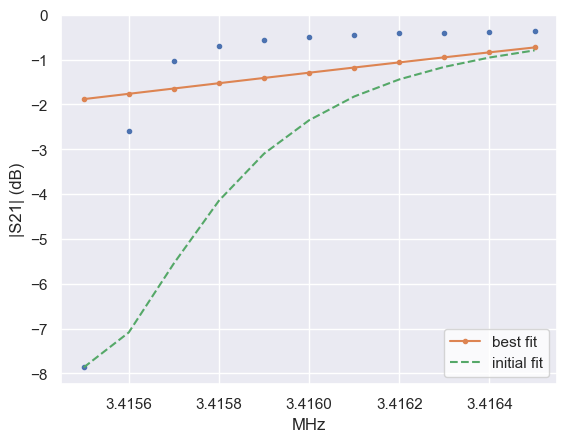

In [34]:
def plot_ri(data, *args, **kwargs):
    plt.plot(data.real, data.imag, *args, **kwargs)


fit_s21 = resonator.eval(params=result.params, f=freq_p1)
guess_s21 = resonator.eval(params=guess_p1, f=freq_p1)

plt.figure()
plot_ri(s21_p1, '.')
plot_ri(fit_s21, '.-', label='best fit')
plot_ri(guess_s21, '--', label='initial fit')
plt.legend()
plt.xlabel('Re(S21)')
plt.ylabel('Im(S21)')

plt.figure()
plt.plot(freq_p1, 20*np.log10(np.abs(s21_p1)), '.')
plt.plot(freq_p1, 20*np.log10(np.abs(fit_s21)), '.-', label='best fit')
plt.plot(freq_p1, 20*np.log10(np.abs(guess_s21)), '--', label='initial fit')
plt.legend()
plt.ylabel('|S21| (dB)')
plt.xlabel('MHz')

In [22]:
s21

array([-0.1547086 +0.37349053j, -0.73568754+0.09202287j,
       -0.84624542+0.26598781j, ..., -0.80099997-0.58356692j,
       -0.80866741-0.57274j   , -0.81126961-0.56881576j])

array([3.4155, 3.4156, 3.4157, ..., 3.4163, 3.4164, 3.4165])

In [24]:
resonator = ResonatorModel()

# Guess initial params
guess = resonator.guess(s21, f=freq, verbose=True)

# Fit
result = resonator.fit(s21, params=guess, f=freq, verbose=True)

# Print results
print(result.fit_report())

fmin=3.4155, fmax=3.4165, f_0_guess=3.415600000000001
Qmin=341.5600000000377, Q_max=34156.000000231295, Q_guess=3415.6000000117533, Q_e_real_guess=4717.312260421705
[[Model]]
    Model(linear_resonator)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 958
    # data points      = 3102
    # variables        = 4
    chi-square         = 185.815401
    reduced chi-square = 0.05997915
    Akaike info crit   = -8724.28086
    Bayesian info crit = -8700.12165
    R-squared          = (1.5336856463233408e+17+5478277470344979j)
[[Variables]]
    f_0:       3.41649999 +/- 2.6228e-04 (0.01%) (init = 3.4156)
    Q:         341.560001 +/- 7.23321953 (2.12%) (init = 3415.6)
    Q_e_real:  181.352457 +/- 9.74271702 (5.37%) (init = 4717.312)
    Q_e_imag: -19.5019783 +/- 9.74094944 (49.95%) (init = 0)
[[Correlations]] (unreported correlations are < 0.100)
    C(Q, Q_e_real)   = +0.9980
    C(f_0, Q_e_imag) = +0.9980


### okay that dataset was not good

In [44]:
# trying new: 

LN2_tandel0_complex = pd.read_csv('/Users/leayamashiro/AliCPT/whispering_gallery/S21_csvs/S11_S21_complex/COMPLEX_0.2to0.5mm_GapSweep_LN2_tanDelta0_3.3875GHz.csv', skiprows=4)

In [61]:
LN2_tandel0_complex.loc[40]

% x_strip (m)                                        0.00021
freq (GHz)                                           3.38815
S11 (1)          -0.013344047816695848-0.062025447067711306i
S21 (1)               -0.7756167525061476+0.549325324731373i
S21_clean             -0.7756167525061476+0.549325324731373j
Name: 40, dtype: object

In [57]:
def clean_complex_csvs(df):
    # Clean up the complex strings (replace 'i' with 'j')
    df['S21_clean'] = df['S21 (1)'].str.replace('i', 'j', regex=False)

    # Convert to actual complex numbers
    s21 = df['S21_clean'].astype(complex).to_numpy()

    # Frequency array
    freq = df['freq (GHz)'].to_numpy()

    return df, s21, freq 

In [79]:
def clean_complex_csvs_gap(df, gaps='all', one_gap=None, gap_start=None, gap_stop=None):
    
    # Clean up the complex strings (replace 'i' with 'j')
    df['S21_clean'] = df['S21 (1)'].str.replace('i', 'j', regex=False)

    if gaps=='one':
        # if only grabbing one frequency
        df = df[df['% x_strip (m)']==one_gap]
        # Convert to actual complex numbers
        s21 = df['S21_clean'].astype(complex).to_numpy()
        # Frequency array
        freq = df['freq (GHz)'].to_numpy()

    elif gaps=='some': 
        df = df[df['% x_strip (m)'].isin(np.arange(gap_start, gap_stop, 0.00001))]
        # Convert to actual complex numbers
        s21 = df['S21_clean'].astype(complex).to_numpy()
        # Frequency array
        freq = df['freq (GHz)'].to_numpy()

    elif gaps=='all':
        # Convert to actual complex numbers
        s21 = df['S21_clean'].astype(complex).to_numpy()
        # Frequency array
        freq = df['freq (GHz)'].to_numpy()
        
    return df, s21, freq

In [77]:
range?

Init signature: range(self, /, *args, **kwargs)
Docstring:     
range(stop) -> range object
range(start, stop[, step]) -> range object

Return an object that produces a sequence of integers from start (inclusive)
to stop (exclusive) by step.  range(i, j) produces i, i+1, i+2, ..., j-1.
start defaults to 0, and stop is omitted!  range(4) produces 0, 1, 2, 3.
These are exactly the valid indices for a list of 4 elements.
When step is given, it specifies the increment (or decrement).
Type:           type
Subclasses:     

In [70]:
LN2_tandel0_complex.isin?

Signature: LN2_tandel0_complex.isin(values: 'Series | DataFrame | Sequence | Mapping') -> 'DataFrame'
Docstring:
Whether each element in the DataFrame is contained in values.

Parameters
----------
values : iterable, Series, DataFrame or dict
    The result will only be true at a location if all the
    labels match. If `values` is a Series, that's the index. If
    `values` is a dict, the keys must be the column names,
    which must match. If `values` is a DataFrame,
    then both the index and column labels must match.

Returns
-------
DataFrame
    DataFrame of booleans showing whether each element in the DataFrame
    is contained in values.

See Also
--------
DataFrame.eq: Equality test for DataFrame.
Series.isin: Equivalent method on Series.
Series.str.contains: Test if pattern or regex is contained within a
    string of a Series or Index.

Examples
--------
>>> df = pd.DataFrame({'num_legs': [2, 4], 'num_wings': [2, 0]},
...                   index=['falcon', 'dog'])
>>> df
  

In [85]:
def get_resonator_fit(s21, freq, want='fit_report_plot'):

    resonator = ResonatorModel()
    # Guess initial params
    guess = resonator.guess(s21, f=freq, verbose=True)
    # Fit
    result = resonator.fit(s21, params=guess, f=freq, verbose=True)
    
    def plot_ri(data, *args, **kwargs):
        plt.plot(data.real, data.imag, *args, **kwargs)
        
    fit_s21 = resonator.eval(params=result.params, f=freq)
    guess_s21 = resonator.eval(params=guess, f=freq)

    if want=='fit_report': 
        # Print results
        print(result.fit_report())

    elif want=='fit_plot': 
        # only plot: 
        plt.figure()
        plot_ri(s21, '.')
        plot_ri(fit_s21, '.-', label='best fit')
        plot_ri(guess_s21, '--', label='initial fit')
        plt.legend()
        plt.xlabel('Re(S21)')
        plt.ylabel('Im(S21)')

        plt.figure()
        plt.plot(freq, 20*np.log10(np.abs(s21)), '.')
        plt.plot(freq, 20*np.log10(np.abs(fit_s21)), '.-', label='best fit')
        plt.plot(freq, 20*np.log10(np.abs(guess_s21)), '--', label='initial fit')
        plt.legend()
        plt.ylabel('|S21| (dB)')
        plt.xlabel('MHz')

    elif want=='fit_report_plot':
        # Print results:
        print(result.fit_report())
        # also plot: 
        plt.figure()
        plot_ri(s21, '.')
        plot_ri(fit_s21, '.-', label='best fit')
        plot_ri(guess_s21, '--', label='initial fit')
        plt.legend()
        plt.xlabel('Re(S21)')
        plt.ylabel('Im(S21)')

        plt.figure()
        plt.plot(freq, 20*np.log10(np.abs(s21)), '.')
        plt.plot(freq, 20*np.log10(np.abs(fit_s21)), '.-', label='best fit')
        plt.plot(freq, 20*np.log10(np.abs(guess_s21)), '--', label='initial fit')
        plt.legend()
        plt.ylabel('|S21| (dB)')
        plt.xlabel('MHz')


In [50]:
LN2_3p38_df, s21_LN23p38, freq_LN23p38 = clean_complex_csvs(LN2_tandel0_complex)

#### trying again with just one gap distance: 

In [65]:
LN23p38_p25_clean, s21_LN23p38_p25, freq_LN23p38_p25 = clean_complex_csvs_gap(LN2_tandel0_complex, gaps='one', one_gap=0.00025)

In [66]:
LN23p38_p25_clean

,% x_strip (m),freq (GHz),S11 (1),S21 (1),S21_clean
155,0.00025,3.38725,-0.06368401796613732-0.12008712534394633i,-0.847822515277969+0.4498469432979345i,-0.847822515277969+0.4498469432979345j
156,0.00025,3.38735,-0.06185766449029617-0.11719263525383486i,-0.8459183690666736+0.4528691399780307i,-0.8459183690666736+0.4528691399780307j
157,0.00025,3.38745,-0.05965631772532776-0.11383644334892015i,-0.8436388270809212+0.45635249063082417i,-0.8436388270809212+0.45635249063082417j
158,0.00025,3.38755,-0.05695806278134663-0.10990307412006163i,-0.84086205078632+0.46041197151154134i,-0.84086205078632+0.46041197151154134j
159,0.00025,3.38765,-0.05358408600161435-0.10523688798128825i,-0.8374091648579729+0.4652030218240504i,-0.8374091648579729+0.4652030218240504j
160,0.00025,3.38775,-0.049263577519620516-0.09962501020085854i,-0.8330092697261087+0.4709379745710707i,-0.8330092697261087+0.4709379745710707j
161,0.00025,3.38785,-0.04356528748666988-0.09276988730716582i,-0.8272310411430626+0.4779138573982736i,-0.8272310411430626+0.4779138573982736j
162,0.00025,3.38795,-0.03576999605183295-0.08425430566554559i,-0.8193553295657956+0.4865467460185471i,-0.8193553295657956+0.4865467460185471j
163,0.00025,3.38805,-0.024599461545963264-0.07349803920613524i,-0.8081041253483199+0.4974149466178338i,-0.8081041253483199+0.4974149466178338j
164,0.00025,3.38815,-0.007603545433438663-0.059767658105473895i,-0.7910282125045025+0.5112487002367038i,-0.7910282125045025+0.5112487002367038j


In [83]:
# trying with a whole bunch of s21 values
p2p3, s21_p2p3, freq_p2p3 = clean_complex_csvs_gap(LN2_tandel0_complex, gaps='some', gap_start=0.0002, gap_stop=0.0003)
p2p3

,% x_strip (m),freq (GHz),S11 (1),S21 (1),S21_clean
0,0.00020,3.38725,-0.06683952491425138-0.11766185134581238i,-0.8304208380990068+0.4963366842581403i,-0.8304208380990068+0.4963366842581403j
1,0.00020,3.38735,-0.06488404432762995-0.11489065209625515i,-0.8283750174267711+0.49922569418367846i,-0.8283750174267711+0.49922569418367846j
2,0.00020,3.38745,-0.06252710578593812-0.11167664105416615i,-0.8259274776950034+0.502556738398175i,-0.8259274776950034+0.502556738398175j
3,0.00020,3.38755,-0.05964727163986083-0.10791838669615403i,-0.8229556349272094+0.5064306887281977i,-0.8229556349272094+0.5064306887281977j
4,0.00020,3.38765,-0.05605557008125994-0.10346827146765716i,-0.8192703786619504+0.5109947154400968i,-0.8192703786619504+0.5109947154400968j
...,...,...,...,...,...
305,0.00029,3.38985,-0.0049014628222803225-0.043890433167437494i,-0.9845927450528408+0.03587556714158107i,-0.9845927450528408+0.03587556714158107j
306,0.00029,3.38995,-0.005041233602315787-0.040526289257169i,-0.9847257963179837+0.039366976683419735i,-0.9847257963179837+0.039366976683419735j
307,0.00029,3.39005,-0.005114276067663903-0.03765761589712621i,-0.9847927085065923+0.0423625923336577i,-0.9847927085065923+0.0423625923336577j
308,0.00029,3.39015,-0.005142778861915498-0.0351835388891171i,-0.984815546964209+0.0449633856310142i,-0.984815546964209+0.0449633856310142j


fmin=3.3872500000000003, fmax=3.3902500000000004, f_0_guess=3.3886499999999997
Qmin=112.95499999999572, Q_max=33886.50000022946, Q_guess=1956.4379896960122, Q_e_real_guess=4326.289435414088
[[Model]]
    Model(linear_resonator)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 513
    # data points      = 558
    # variables        = 4
    chi-square         = 16.8400713
    reduced chi-square = 0.03039724
    Akaike info crit   = -1945.33353
    Bayesian info crit = -1928.03609
    R-squared          = (9624090940847960-5695687190169966j)
[[Variables]]
    f_0:       3.39024999 +/- 0.00136615 (0.04%) (init = 3.38865)
    Q:         112.955001 +/- 38.3148358 (33.92%) (init = 1956.438)
    Q_e_real:  57.7917017 +/- 5.70416543 (9.87%) (init = 4326.289)
    Q_e_imag:  16.9104881 +/- 5.71980535 (33.82%) (init = 0)
[[Correlations]] (unreported correlations are < 0.100)
    C(f_0, Q_e_imag) = +0.9261
    C(Q, Q_e_real)   = -0.9258
    C(Q, Q_e_imag)   = -0.3766
   

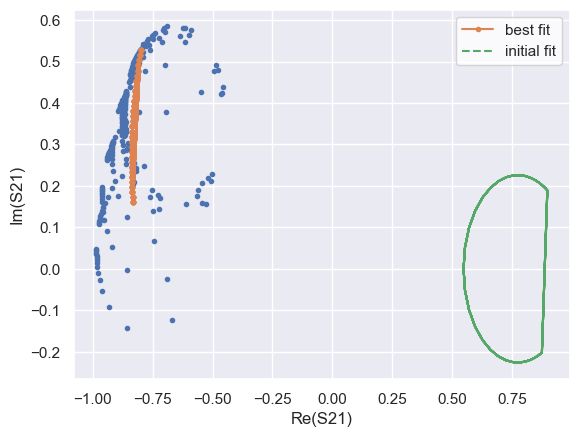

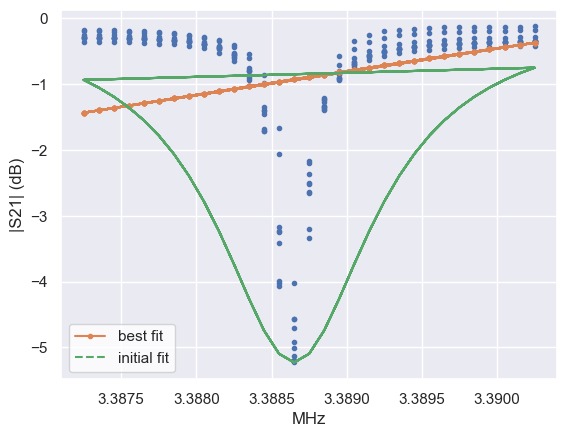

In [84]:
get_resonator_fit(s21_p2p3, freq_p2p3, want='fit_report_plot')